# General Publication Statistics about a Research Organization

This Notebook shows how it's possible to extract basic indicators about a research organization programmatically, using the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) and Jupyter Notebooks. 


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import os, sys, time, json
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(KEY, ENDPOINT)
else:
  KEY = ""
  dimcli.login(KEY, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.8.2)
Connected to: https://app.dimensions.ai - DSL v1.28
Method: dsl.ini file


## Choose a Research Organization

For the purpose of this exercise, we will are going to use [grid.168010.e](https://grid.ac/institutes/grid.168010.e) (Stanford University). Feel free though to change the parameters below as you want, eg by [choosing another GRID organization](https://grid.ac/institutes).


In [2]:
GRIDID = "grid.168010.e" #@param {type:"string"}

def grids_url(grids):
    "gen link to Dimensions webapp"
    root = "https://app.dimensions.ai/discover/publication?or_facet_research_org="
    return root + "&or_facet_research_org=".join([x for x in grids])

from IPython.core.display import display, HTML
display(HTML('---<br /><a href="{}">Preview {} Dimensions &#x29c9;</a>'.format(grids_url([GRIDID]), GRIDID)))

## Publications output by year 

In [3]:
tot = dsl.query(f"""search publications where research_orgs.id="{GRIDID}" return publications limit 1""", verbose=False).count_total
print(f"{GRIDID} has a total of {tot} publications in Dimensions")

grid.168010.e has a total of 249953 publications in Dimensions


Returned Year: 100
Time: 0.56s


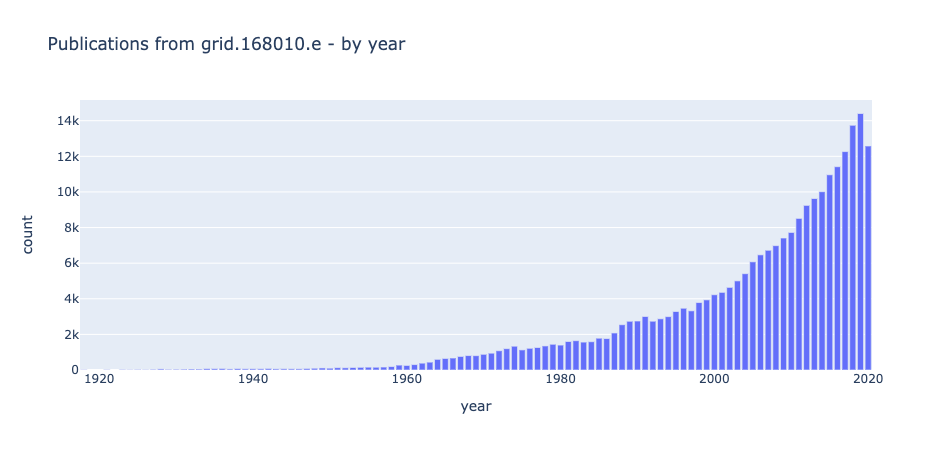

In [4]:
df = dsl.query(f"""search publications where research_orgs.id="{GRIDID}" return year limit 100""").as_dataframe() 
df.rename(columns={"id": "year"}, inplace=True)
#
px.bar(df, x="year", y="count", 
       title=f"Publications from {GRIDID} - by year")

## Publications most cited in last 2 years

In [5]:
data = dslquery(f"""search publications where research_orgs.id="{GRIDID}" 
        return publications[doi+title+recent_citations+category_for+journal] 
        sort by recent_citations limit 100""")
df = data.as_dataframe()
df.head(10)[['title', 'doi', 'recent_citations', 'journal.title']]

Returned Publications: 100 (total = 249953)
Time: 0.97s


,title,doi,recent_citations,journal.title
0,ImageNet Large Scale Visual Recognition Challenge,10.1007/s11263-015-0816-y,7321,International Journal of Computer Vision
1,A global reference for human genetic variation,10.1038/nature15393,4499,Nature
2,"The Elements of Statistical Learning, Data Min...",10.1007/978-0-387-84858-7,4458,NaN
3,An integrated encyclopedia of DNA elements in ...,10.1038/nature11247,4229,Nature
4,Compressed Sensing,10.1109/tit.2006.871582,4082,IEEE Transactions on Information Theory
5,Planck 2015 results - XIII. Cosmological param...,10.1051/0004-6361/201525830,3707,Astronomy & Astrophysics
6,Building Theories from Case Study Research,10.5465/amr.1989.4308385,3559,Academy of Management Review
7,"Global, regional, and national prevalence of o...",10.1016/s0140-6736(14)60460-8,3388,The Lancet
8,Regularization and variable selection via the ...,10.1111/j.1467-9868.2005.00503.x,3229,Journal of the Royal Statistical Society Serie...
9,phyloseq: An R Package for Reproducible Intera...,10.1371/journal.pone.0061217,3086,PLoS ONE


## Publications most cited - all time

In [6]:
data = dslquery(f"""search publications 
                where research_orgs.id="{GRIDID}" 
                return publications[doi+title+times_cited+category_for+journal] 
                sort by times_cited limit 1000""")
df = data.as_dataframe()
df.head(10)[['title', 'doi', 'times_cited', 'journal.title']]

Returned Publications: 1000 (total = 249953)
Time: 2.04s


,title,doi,times_cited,journal.title
0,Initial sequencing and analysis of the human g...,10.1038/35057062,15997,Nature
1,Compressed Sensing,10.1109/tit.2006.871582,15811,IEEE Transactions on Information Theory
2,The american rheumatism association 1987 revis...,10.1002/art.1780310302,15717,Arthritis & Rheumatology
3,Cluster analysis and display of genome-wide ex...,10.1073/pnas.95.25.14863,12325,Proceedings of the National Academy of Science...
4,Building Theories from Case Study Research,10.5465/amr.1989.4308385,10920,Academy of Management Review
5,The 1982 revised criteria for the classificati...,10.1002/art.1780251101,10912,Arthritis & Rheumatology
6,Atomic Force Microscope,10.1103/physrevlett.56.930,10434,Physical Review Letters
7,An integrated encyclopedia of DNA elements in ...,10.1038/nature11247,10204,Nature
8,Molecular portraits of human breast tumours,10.1038/35021093,9888,Nature
9,ImageNet Large Scale Visual Recognition Challenge,10.1007/s11263-015-0816-y,9464,International Journal of Computer Vision


## Publications most cited : which research areas?

In [28]:
data = dslquery(f"""search publications 
                    where research_orgs.id="{GRIDID}" 
                    return publications[doi+title+times_cited+category_for+journal] 
                    sort by times_cited limit 1000""")

Returned Publications: 1000 (total = 249953)
Time: 1.38s


Most publications have one or more associated Field Of Research (FOR) category, which is represented in the JSON like this:

```
{'category_for' : [{'id': '3292', 'name': '1402 Applied Economics'}, 
                    {'id': '3177', 'name': '1117 Public Health and Health Services'}]
                    }`
```

However since some publications may not have an associated FOR category, the resulting JSON in some cases may not have `category_for` as a key. Since we want to import the data into pandas we need to ensure the key is always there and has an empty list when no category is available.  

In [29]:
# dimcli.shortcuts.normalize_key takes: field name / json list / value to add when the field is not found
normalize_key("category_for", data.publications, [])

In [30]:
df = pd.json_normalize(data.publications, record_path='category_for', meta=['doi', 'title', 'times_cited', ], errors='ignore' )
df.head()

,id,name,doi,title,times_cited
0,2620,0604 Genetics,10.1038/35057062,Initial sequencing and analysis of the human g...,15997
1,2206,06 Biological Sciences,10.1038/35057062,Initial sequencing and analysis of the human g...,15997
2,2208,08 Information and Computing Sciences,10.1109/tit.2006.871582,Compressed Sensing,15811
3,2209,09 Engineering,10.1109/tit.2006.871582,Compressed Sensing,15811
4,2210,10 Technology,10.1109/tit.2006.871582,Compressed Sensing,15811


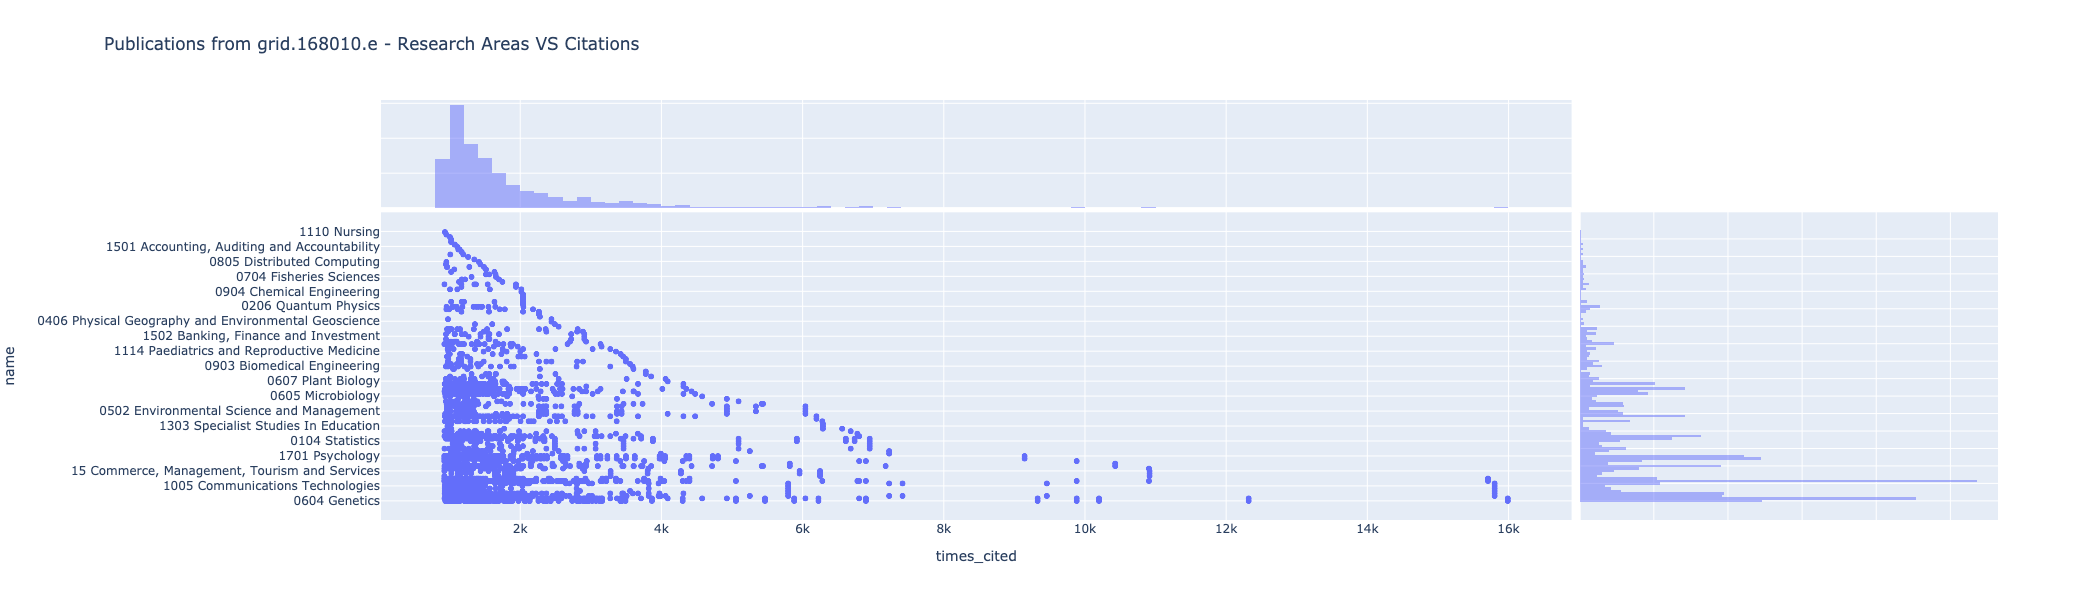

In [31]:
px.scatter(df, 
           x="times_cited", y="name", 
           marginal_x="histogram", 
           marginal_y="histogram", 
           hover_data=["doi", "title"],
           height=600,
           title=f"Publications from {GRIDID} - Research Areas VS Citations")

## Publications most cited : which journals?

Returned Publications: 1000 (total = 249953)
Time: 1.45s


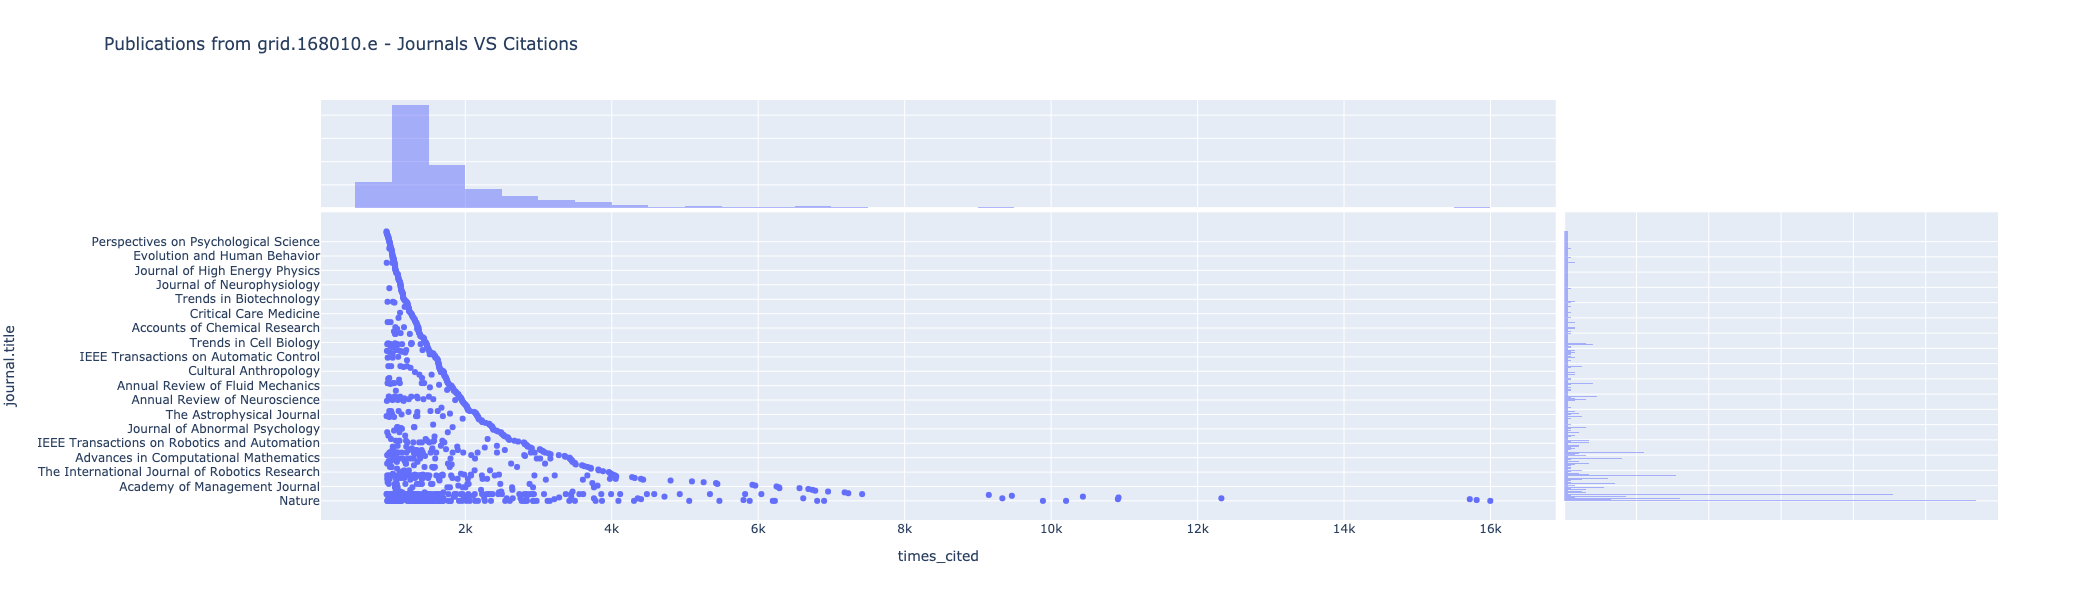

In [32]:
data = dslquery(f"""search publications 
                    where research_orgs.id="{GRIDID}" 
                    return publications[doi+title+times_cited+category_for+journal] 
                    sort by times_cited limit 1000""")

df = data.as_dataframe()
#
px.scatter(df, 
           x="times_cited", y="journal.title", 
           marginal_x="histogram", 
           marginal_y="histogram", 
           height=600,
           title=f"Publications from {GRIDID} - Journals VS Citations")

## Top Funders (by aggregated funding amount)

In [33]:
fundersdata = dsl.query(f"""search grants 
                        where research_orgs.id="{GRIDID}" 
                        return funders aggregate funding 
                        sort by funding""")
df = fundersdata.as_dataframe()
df.head(10)

Returned Funders: 20
Time: 0.53s


,id,count,funding,country_name,acronym,state_name,city_name,name,types,longitude,linkout,latitude
0,grid.48336.3a,788,1.059476e+09,United States,NCI,Maryland,Rockville,National Cancer Institute,[Government],-77.101190,[http://www.cancer.gov/],39.004326
1,grid.280785.0,770,1.040659e+09,United States,NIGMS,Maryland,Bethesda,National Institute of General Medical Sciences,[Facility],-77.099380,[http://www.nigms.nih.gov/Pages/default.aspx],38.997833
2,grid.419681.3,567,7.449747e+08,United States,NIAID,Maryland,Bethesda,National Institute of Allergy and Infectious D...,[Facility],-77.111830,[http://www.niaid.nih.gov/Pages/default.aspx],39.066647
3,grid.279885.9,609,7.437638e+08,United States,NHLBI,Maryland,Bethesda,National Heart Lung and Blood Institute,[Facility],-77.100945,[http://www.nhlbi.nih.gov/],39.004280
4,grid.457875.c,1292,6.756204e+08,United States,NSF MPS,Virginia,Arlington,Directorate for Mathematical & Physical Sciences,[Government],-77.110990,[http://www.nsf.gov/dir/index.jsp?org=MPS],38.880566
5,grid.280128.1,140,6.005008e+08,United States,NHGRI,Maryland,Bethesda,National Human Genome Research Institute,[Facility],-77.096930,[https://www.genome.gov/],38.996967
6,grid.416870.c,523,5.996880e+08,United States,NINDS,Maryland,Bethesda,National Institute of Neurological Disorders a...,[Facility],-77.101180,[http://www.ninds.nih.gov/],39.003826
7,grid.416868.5,521,5.463138e+08,United States,NIMH,Maryland,Bethesda,National Institute of Mental Health,[Facility],-77.104570,[https://www.nimh.nih.gov/index.shtml],39.003693
8,grid.418557.a,137,4.777585e+08,United States,CIRM,California,San Francisco,California Institute for Regenerative Medicine,[Government],-122.392340,[https://www.cirm.ca.gov/],37.778034
9,grid.457799.1,131,4.298322e+08,United States,NSF EHR,Virginia,Arlington,Directorate for Education & Human Resources,[Government],-77.111000,[http://www.nsf.gov/dir/index.jsp?org=EHR],38.880580


## Top funders split by country of the funder

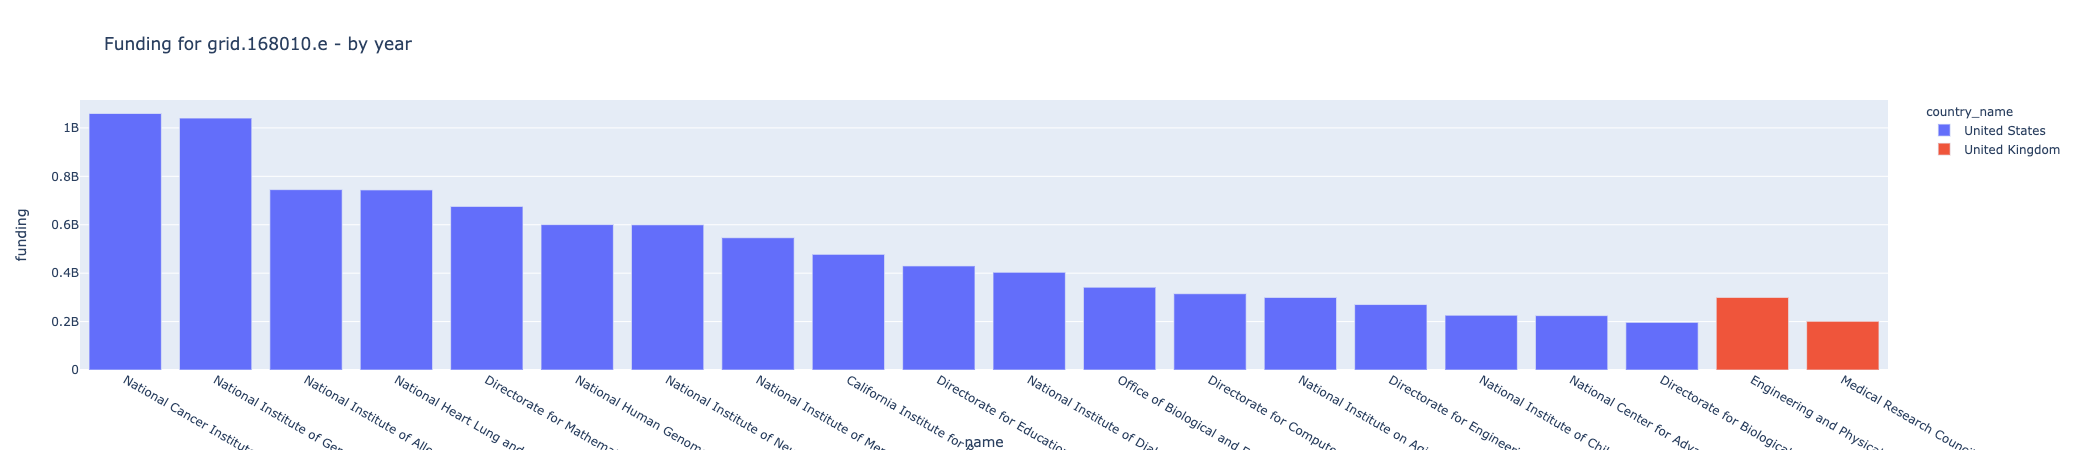

In [34]:
px.bar(df, 
       x="name", y="funding", 
       color="country_name",
       title=f"Funding for {GRIDID} - by year")

## Correlation between No of Publications VS Funding

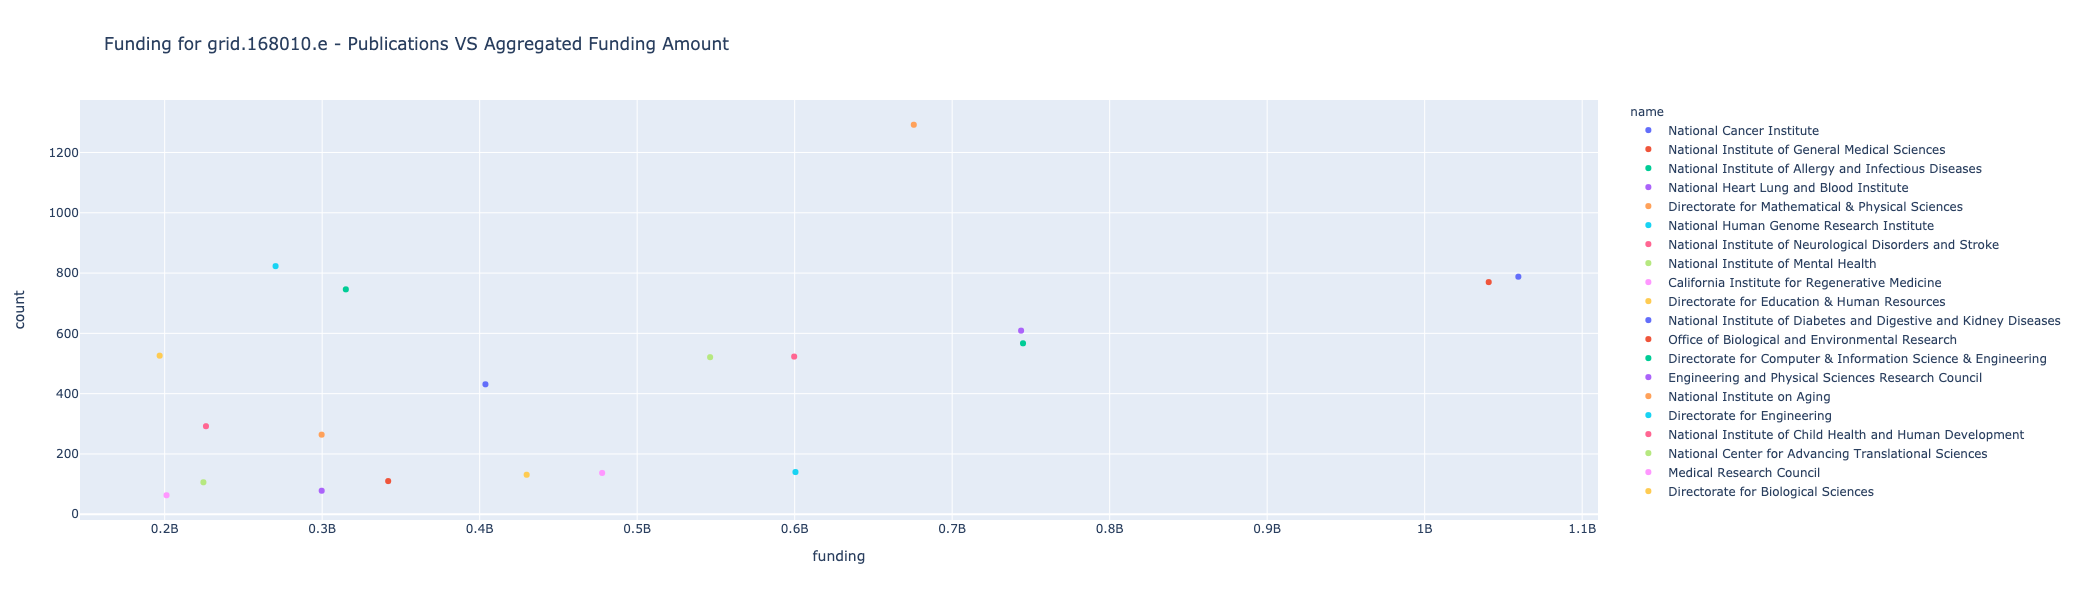

In [35]:
px.scatter(df, 
           x="funding", y="count", 
           color="name", 
           height=600,
           title=f"Funding for {GRIDID} - Publications VS Aggregated Funding Amount")